In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from MMADDPG import MADDPG

In [2]:
# get the default brain
env = UnityEnvironment(file_name="/home/ahmed/Desktop/RL/drlnd/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
print(num_agents)
action_size = brain.vector_action_space_size
print(action_size)
states = env_info.vector_observations
state_size = states.shape[1]
print(state_size)
random_seed = 0

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


2
2
24


In [3]:
maddpg = MADDPG(state_size, action_size, random_seed)

In [4]:
def main(n_episodes=5000):
    '''
    -------------------------------------------
    Parameters
    
    n_episodes: # of episodes that the agent is training for
    -------------------------------------------
    '''
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]             # turn on train mode of the environment
        states = env_info.vector_observations                         # get the current state for each agent
        #states = torch.from_numpy(states).float().to(device)
        #maddpg.reset()                                                # reset the OU noise parameter 
        ep_scores = np.zeros(num_agents)                              # initialize the score for each agent
        maddpg.reset_agents()
        while True:
            actions = maddpg.act(states)                             # select an action for each agent
            #print(actions)
            #actions = [t.numpy() for t in actions]
            env_info = env.step(actions)[brain_name]                  # send all actions to the environment
            next_states = env_info.vector_observations                # get next state for each agent
            rewards = env_info.rewards                                # get reward for each agent
            dones = env_info.local_done                               # check if episode finished
            maddpg.step(states, actions, rewards, next_states, dones) # agents record enviroment response in recent step
            states = next_states                                      # set the state as the next state for the following step for each agent
            ep_scores += rewards                                      # update the total score
            if np.any(dones):                                         # exit loop if episode for any agent finished
                break 
                
        scores_deque.append(np.max(ep_scores))
        scores.append(ep_scores)
        
        # print average epsiode score and average 100-episode score for each episode
        print('\rEpisode {} \tMax Score: {:.3f} \tAverage Max Score: {:.3f}'.format(i_episode, np.max(ep_scores), np.mean(scores_deque)), end="")  
        if i_episode % 100 == 0:
            print('\rEpisode {} \tMax Score: {:.3f} \tAverage Max Score: {:.3f}'.format(i_episode, np.max(ep_scores), np.mean(scores_deque)))  
        
        # print and save actor and critic weights when a score of +30 over 100 episodes has been achieved
        if np.mean(scores_deque) >= 0.5:
            for i in range(num_agents):
                torch.save(maddpg.maddpg_agents[i].actor_local.state_dict(), 'checkpoint_actor_{}_final.pth'.format(i))
                torch.save(maddpg.maddpg_agents[i].critic_local.state_dict(), 'checkpoint_critic_{}_final.pth'.format(i))
            print('\nEnvironment solved in {:d} episodes!\tAverage Max Score: {:.3f}'.format(i_episode-100, np.mean(scores_deque)))
            break
    return scores

scores = main()

Episode 100 	Max Score: 0.000 	Average Max Score: 0.006
Episode 200 	Max Score: 0.000 	Average Max Score: 0.007
Episode 300 	Max Score: 0.090 	Average Max Score: 0.003
Episode 400 	Max Score: 0.000 	Average Max Score: 0.006
Episode 500 	Max Score: 0.000 	Average Max Score: 0.005
Episode 600 	Max Score: 0.000 	Average Max Score: 0.007
Episode 700 	Max Score: 0.000 	Average Max Score: 0.008
Episode 800 	Max Score: 0.000 	Average Max Score: 0.008
Episode 900 	Max Score: 0.000 	Average Max Score: 0.003
Episode 1000 	Max Score: 0.000 	Average Max Score: 0.009
Episode 1100 	Max Score: 0.000 	Average Max Score: 0.004
Episode 1200 	Max Score: 0.000 	Average Max Score: 0.013
Episode 1300 	Max Score: 0.000 	Average Max Score: 0.010
Episode 1400 	Max Score: 0.000 	Average Max Score: 0.008
Episode 1500 	Max Score: 0.000 	Average Max Score: 0.004
Episode 1600 	Max Score: 0.000 	Average Max Score: 0.008
Episode 1700 	Max Score: 0.000 	Average Max Score: 0.010
Episode 1800 	Max Score: 0.000 	Average 

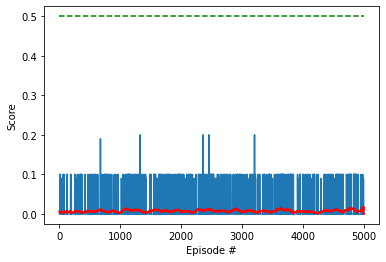

In [5]:
fig = plt.figure()

# plot scores
t = np.arange(1,len(scores)+1)
s = []
i = 0
while i < len(scores):
    s.append(np.mean([np.max(s_ep) for s_ep in scores[i:i+100]]))
    i += 1

# plot max score/episode
plt.plot(np.arange(1, len(scores)+1), [np.max(s_ep) for s_ep in scores])
# plot average of max per next 100 episodes
plt.plot(t, s, c='r', linewidth=2)
# plot threshold line at +0.5
plt.hlines(0.5, 0, len(scores), colors='g', linestyles='dashed')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

env.close()